In [4]:
#your work should only start with the following code
df=pd.read_csv("A2_Data.csv")

In [3]:
#You need to import all the required libraries in thi cell
import warnings
import pandas as pd 
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
My_vectorizer = TfidfVectorizer ()
warnings.filterwarnings("ignore")
from sklearn.decomposition import TruncatedSVD
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import os
import nltk
import emojis
import re
from sklearn.pipeline import Pipeline
import string
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from gensim.models.coherencemodel import CoherenceModel
from IPython import display

[nltk_data] Downloading package punkt to /Users/sselemahs/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sselemahs/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Text preparation

In [17]:
df1= df.reset_index(drop=True)
df1 = df.loc[(df['user_followers'] > df['user_followers'].median()) & (df['tweet_source'] != 'Twitter for iPhone') &(df['user_friends']>df['user_friends'].median()) &(df['user_favourites']>df['user_favourites'].median())]

df2 = df1[["Unnamed: 0","text","RiseFall"]]

#delete emotion and tone indications between brackets
df2['text']=df2['text'].str.replace(r"\(.*\)","")
#Replace one character for another
df2['text'] = df2['text'].str.replace('.', '')
df2['text'] = df2['text'].str.replace(',', '')
#Strip unnecessary spaces
df2['text']= df2['text'].str.strip()

#tokenising
df3 = df2['text'].apply(word_tokenize)
#case folding
df4 = df3.apply(lambda x: [word.lower() for word in x])

#Stopwords Removal
My_stop_words = stopwords.words("English")
My_stop_words = My_stop_words + ['bitcoin','eth','btc','crypto','cryptocurrency','blockchain','project','binance','bnb','bsc','amp','tco','ethereum','market','price','buy','sell','polygon','defi','bullish','cryptocurrencies']
df5 = df4.apply(lambda x: [word for word in x if word not in My_stop_words])  

#Stemming
My_stemmer = SnowballStemmer("english")
df6 = df5.apply(lambda x:[My_stemmer.stem(word) for word in x])
 
#Lemmatizer
wn = nltk.WordNetLemmatizer()
def lemmatizing(df3):
    text = [wn.lemmatize(word) for word in df3]
    return text
df_lemmatized = df5.apply(lambda x:lemmatizing (x))

#Enriching data
df7 = df6.apply(lambda x:" ".join(x))
df_enriched=df2
df_enriched["Stemmed_text"]=df7

df8 = df_lemmatized.apply(lambda x:" ".join(x))
df_enriched=df2
df_enriched["Lematized_text"]=df8

·The process of text preparation is data cleaning, tokenising, case folding, stop words removal, lemmatizing, and enriching the data.
·To exclude the invalid accounts, I only select the users whose friends, followers, favourites are above median into the analysis part. 
·Instead of getting rid of all the punctuations, I chose to only move the ',' and '.'. And I tried to delete all the unnecessary spaces and the content within the brackets, which could be helpful while implementing the word cloud later.
·Adding some stop words regarding to the crypto currency.

### Feature generation 1 - date information

In [1]:
#group by the date information
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df_date=df[['date']]
df.groupby('RiseFall')['month'].mean()

df['date'] = pd.to_datetime(df['date'], dayfirst=True)
s = df.resample('M', on='date')['Unnamed: 0'].size()
s.index = s.index.strftime('%b %Y')
print(s)

NameError: name 'pd' is not defined

I extract the date information and find out almost half of the tweets were posted in January. One of the reasons could be that it is the time of financial statements announcement, which leads to more discussion in twitter and stock price fluctuation. So, we need to distinguish the impact from statement itself or the discussion. By using the group by function, we can see that the price tends to decrease in January and after that, the price tends to rise.

### Feature generation 2 - Emoji count

In [179]:
df1["Emoji Count"] = df1['text'].apply(lambda x : emojis.count(str(x)))
df1.groupby('RiseFall')['Emoji Count'].mean()

RiseFall
Equal    1.087223
Fall     0.983495
Rise     0.962963
Name: Emoji Count, dtype: float64

I calculate the emoji usage in each twitter and check whether it has a relation with the stock price. It showed that the twitter that does not cause the price movement used slightly more emojis, which is 1.07, and 0.98 and 0.95 for fall and rise respectively. On average each twitter uses at least one emoji. 


### Feature generation 3 - SVD

In [18]:
#TFIDF
My_vectorizer = TfidfVectorizer ()
TFIDF=My_vectorizer.fit_transform(df_enriched["Lematized_text"])
len(My_vectorizer.get_feature_names())

#SVD
My_SVD = TruncatedSVD(n_components=3, n_iter=100)
SVD_Note= My_SVD.fit_transform(TFIDF)
df_enriched[["SVD1","SVD2","SVD3"]] = SVD_Note
My_SVD.explained_variance_ratio_.sum()

scores =[]
for comp in range(3,10):
    My_SVD = TruncatedSVD(n_components=comp, n_iter=100)
    SVD_Note= My_SVD.fit_transform(TFIDF)
    scores.append((comp,My_SVD.explained_variance_ratio_.sum()))
scores

[(3, 0.024847991838320614),
 (4, 0.0312642158190396),
 (5, 0.037624512712902985),
 (6, 0.04311523625432431),
 (7, 0.048306117259418475),
 (8, 0.05270944981859629),
 (9, 0.05704017096278372)]

First, TF-IDF is used to allocating weights to each of the tokens. Then I use SVD to reduce the dimensions and keep the important information at the same time.

### Feature generation 4 - Sentiment

In [20]:
My_sentiment_analyser = SentimentIntensityAnalyzer()
sentimental_text_list = []
for sentence in df_enriched ["Lematized_text"]:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_text_list.append(text_score)
df_enriched["Sentiment"] = sentimental_text_list
df_enriched.head()
df_enriched['Sentiment'].mean()

0.2689002564906439

In sentiment analysis, we can figure out the semantic orientation of each tweet by checking the compounded figure. The overall average sentiment is 0.2689. It means that the tweets people post turn out to be positive. Among the price movement, 40% is equal, 40% is rise and 30% is fall.

### Feature generation 5 - Check text length and percentafe of punctuation in text

In [188]:
df_len = df1[['text','RiseFall']]
df_ori_len=df[['text','RiseFall']]

df_len['word_count'] = df_len["text"].apply(lambda x: len(str(x).split(" ")))
df_len['char_count'] = df_len["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df_len['sentence_count'] = df["text"].apply(lambda x: len(str(x).split(".")))
df_len['avg_word_length'] = df_len['char_count'] / df_len['word_count']
df_len['avg_sentence_lenghth'] = df_len['word_count'] / df_len['sentence_count']

df_ori_len['word_count'] = df_ori_len["text"].apply(lambda x: len(str(x).split(" ")))
df_len.groupby('RiseFall')['word_count'].mean()
df_len.groupby('RiseFall')['char_count'].mean()
df_len.groupby('RiseFall')['sentence_count'].mean()
df_len.groupby('RiseFall')['avg_word_length'].mean()
df_len.groupby('RiseFall')['avg_sentence_lenghth'].mean()

RiseFall
Equal    10.160084
Fall      9.963738
Rise     10.293767
Name: avg_sentence_lenghth, dtype: float64

I work out the word count, character count in one sentence and the sentence count in one tweet. The word limit in one tweet is 280 words. In conclusion, there are not much difference of word counts between price movements. In average, there are three sentences and contains 25 words. So, people tend to write short tweets instead of a long paragraph running all the word limits. We can also imply that people like to read short tweets which contains blasting information rather than an article elaborating it.

### Visualization 1 - Wordcloud

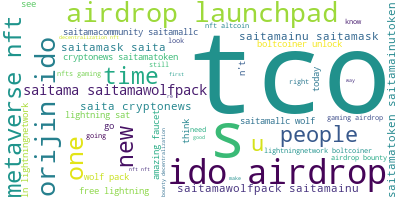

In [24]:
#You can use only this cell for text visual 1.
My_WordCloud = WordCloud(background_color="white", max_words=50)

# Join the different tweets titles together.
My_Long_String =','.join(list(df8.values))

# Generate a word cloud & visualize it
My_WordCloud.generate(My_Long_String)
My_WordCloud.to_image()

The word cloud shows the frequent word people use in their tweets. ‘Metaverse’ is not related to bitcoin directly while it is still a hot topic about technology firms and future life. If the metaverse is realized, then there is chance that crypto currency could fully replace the money in real life. Similar as ‘NFT’, being labelled as virtual ownership of real word items, could be more popular in the future.Other frequent words including launchpad, and ido is regards to the crypto platform.  ‘Airdrop’ seemed to be related to the ‘Apple’ while it is a notion of transferring cryptos. 


### Visualization 2 - Topic_modelling

In [201]:
#Split the dataset based on sentiment score
positive = df_enriched[df_enriched['Sentiment'] >0.05]
negative = df_enriched[df_enriched['Sentiment'] <-0.05]

negative['Lematized_text'].replace({r'[^\w\s]+': ''}, regex=True, inplace =True)
negative=negative[['Lematized_text']]
negative0 = negative['Lematized_text'].apply(word_tokenize)
negative_ = negative0.apply(lambda x: [word for word in x if word not in My_stop_words])  

#Topic modelling for negative sentiment data
My_id2word = corpora.Dictionary(negative_)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in negative_]

# Build LDA model

number_of_topics = 5
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))
gensimvis.prepare(My_LDA_negative, My_Corpus, My_id2word)

#Topic modelling for positive sentiment data
positive['Lematized_text'].replace({r'[^\w\s]+': ''}, regex=True, inplace =True)
positive = positive['Lematized_text'].apply(word_tokenize)
My_stop_words = stopwords.words("English")
My_stop_words = My_stop_words + ['bitcoin','eth','btc','crypto','cryptocurrency','blockchain','project','binance','bnb','bsc','amp','tco','ethereum','market','price','buy','sell','polygon','defi','bullish','cryptocurrencies']
positive_ = positive.apply(lambda x: [word for word in x if word not in My_stop_words])  
My_id2word_positive = corpora.Dictionary(positive_)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in positive_]

# Build LDA model
number_of_topics = 3
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))

gensimvis.prepare(My_LDA_positive, My_Corpus, My_id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.057532 -0.003606       1        1  36.387359
0     -0.033293 -0.032567       2        1  35.478796
2     -0.024239  0.036173       3        1  28.133845, topic_info=                  Term        Freq        Total Category  logprob  loglift
1485                ln  614.000000   614.000000  Default  30.0000  30.0000
2431               oil  657.000000   657.000000  Default  29.0000  29.0000
5258            faucet  612.000000   612.000000  Default  28.0000  28.0000
135                sat  711.000000   711.000000  Default  27.0000  27.0000
2269  lightningnetwork  644.000000   644.000000  Default  26.0000  26.0000
...                ...         ...          ...      ...      ...      ...
198          saitamask  219.187683   579.331701   Topic3  -5.8510   0.2963
373       nftcommunity  225.273676   718.430407   Topic3  -5.8236   0.1084
521               free  255.602333  1477.404918   Topic3  -5.6973  -0.4862
1387             token  224.041002   765.503869   Topic3  -5.8291   0.0395
33                 one  225.501957  1059.724342   Topic3  -5.8226  -0.2792

[277 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
6499       1  0.078118       005
6499       2  0.156235       005
6499       3  0.781176       005
7082       1  0.963474  01212022
14723      2  0.837527      1617
...      ...       ...       ...
5168       3  0.030925       zec
14261      1  0.937655    एमएलएम
14261      3  0.029302    एमएलएम
14262      1  0.966308     बटकइन
14262      3  0.029282     बटकइन

[550 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [203]:

#Topic modelling for negative sentiment data
My_id2word = corpora.Dictionary(negative_)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in negative_]

# Build LDA model

number_of_topics = 5
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))
gensimvis.prepare(My_LDA_negative, My_Corpus, My_id2word)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015672 -0.071288       1        1  22.455092
0     -0.105071  0.032861       2        1  22.156179
3      0.031542  0.051626       3        1  19.361403
4      0.062444  0.029713       4        1  18.138322
2      0.026757 -0.042912       5        1  17.889003, topic_info=           Term        Freq       Total Category  logprob  loglift
5135     shinja  494.000000  494.000000  Default  30.0000  30.0000
5131   shibnobi  258.000000  258.000000  Default  29.0000  29.0000
1010     missed  357.000000  357.000000  Default  28.0000  28.0000
14775      ceek  141.000000  141.000000  Default  27.0000  27.0000
10346    hacked   87.000000   87.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1683        ada   40.415441  156.390233   Topic5  -6.0332   0.3678
648           u   44.204749  201.460787   Topic5  -5.9436   0.2042
71           nt   59.003007  555.699235   Topic5  -5.6549  -0.5217
271         get   48.086268  298.498992   Topic5  -5.8594  -0.1048
375     opensea   40.994761  200.729550   Topic5  -6.0190   0.1325

[432 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
5268       4  0.672884          00
5268       5  0.224295          00
12521      3  0.794532         034
8611       3  0.894567        0day
13571      1  0.190282     0xazuki
...      ...       ...         ...
331        3  0.118211        year
331        4  0.295528        year
331        5  0.151048        year
13500      4  0.748288       youth
5341       5  0.757723  ztexchange

[1009 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

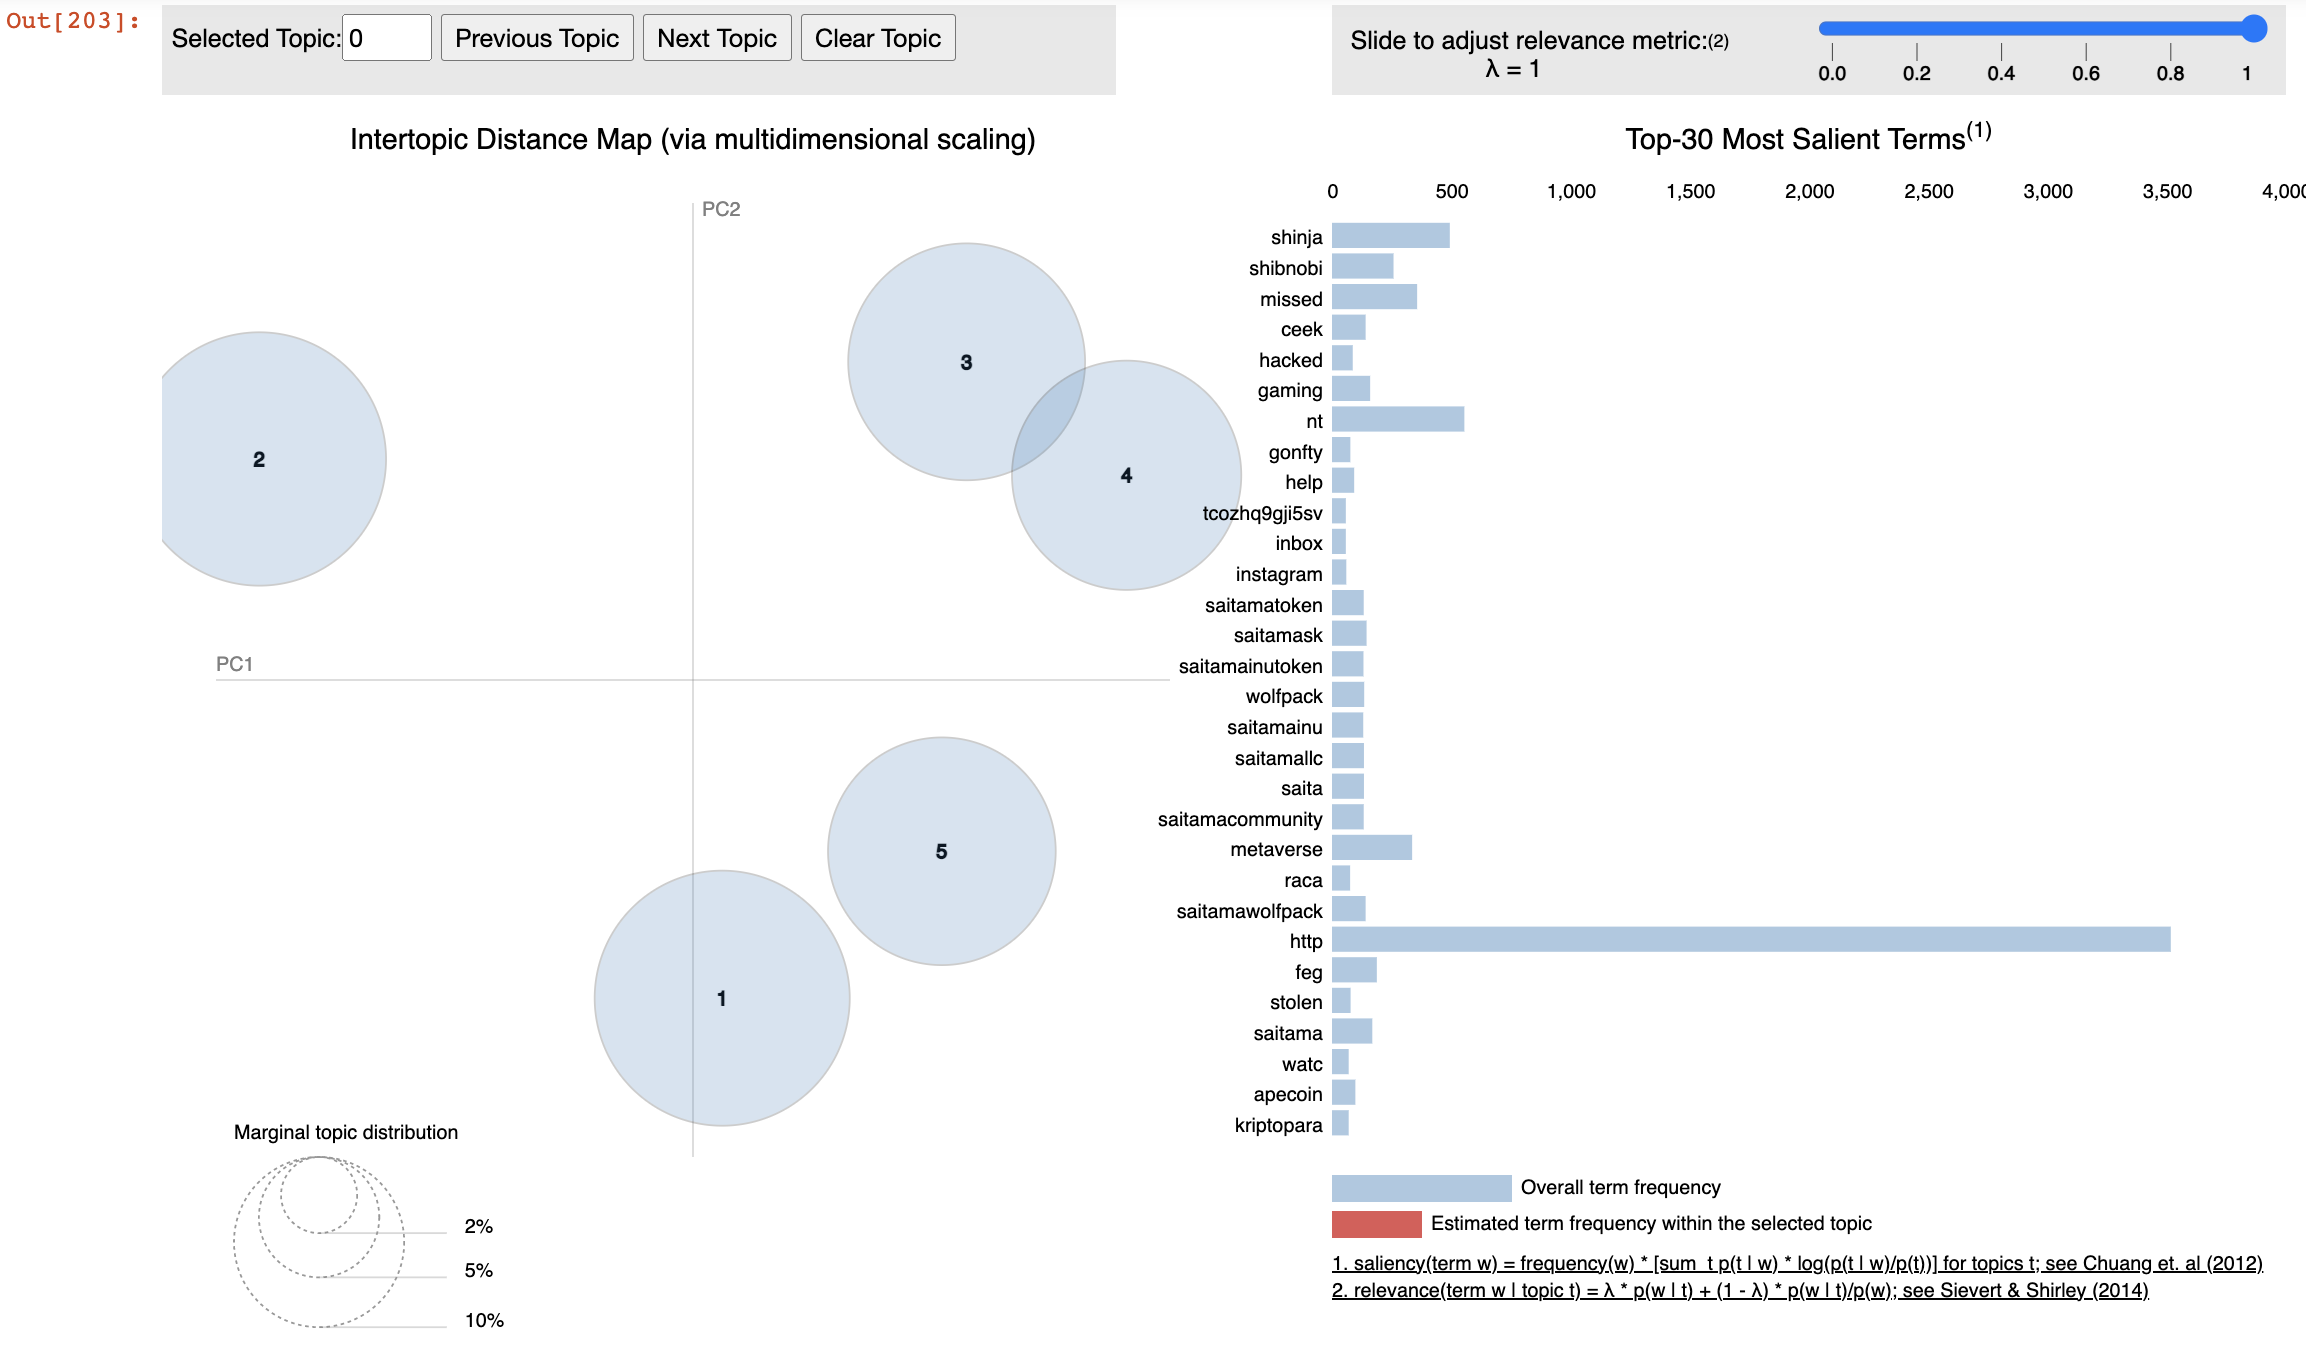

In [207]:
display.Image("./LDA_positive.png")

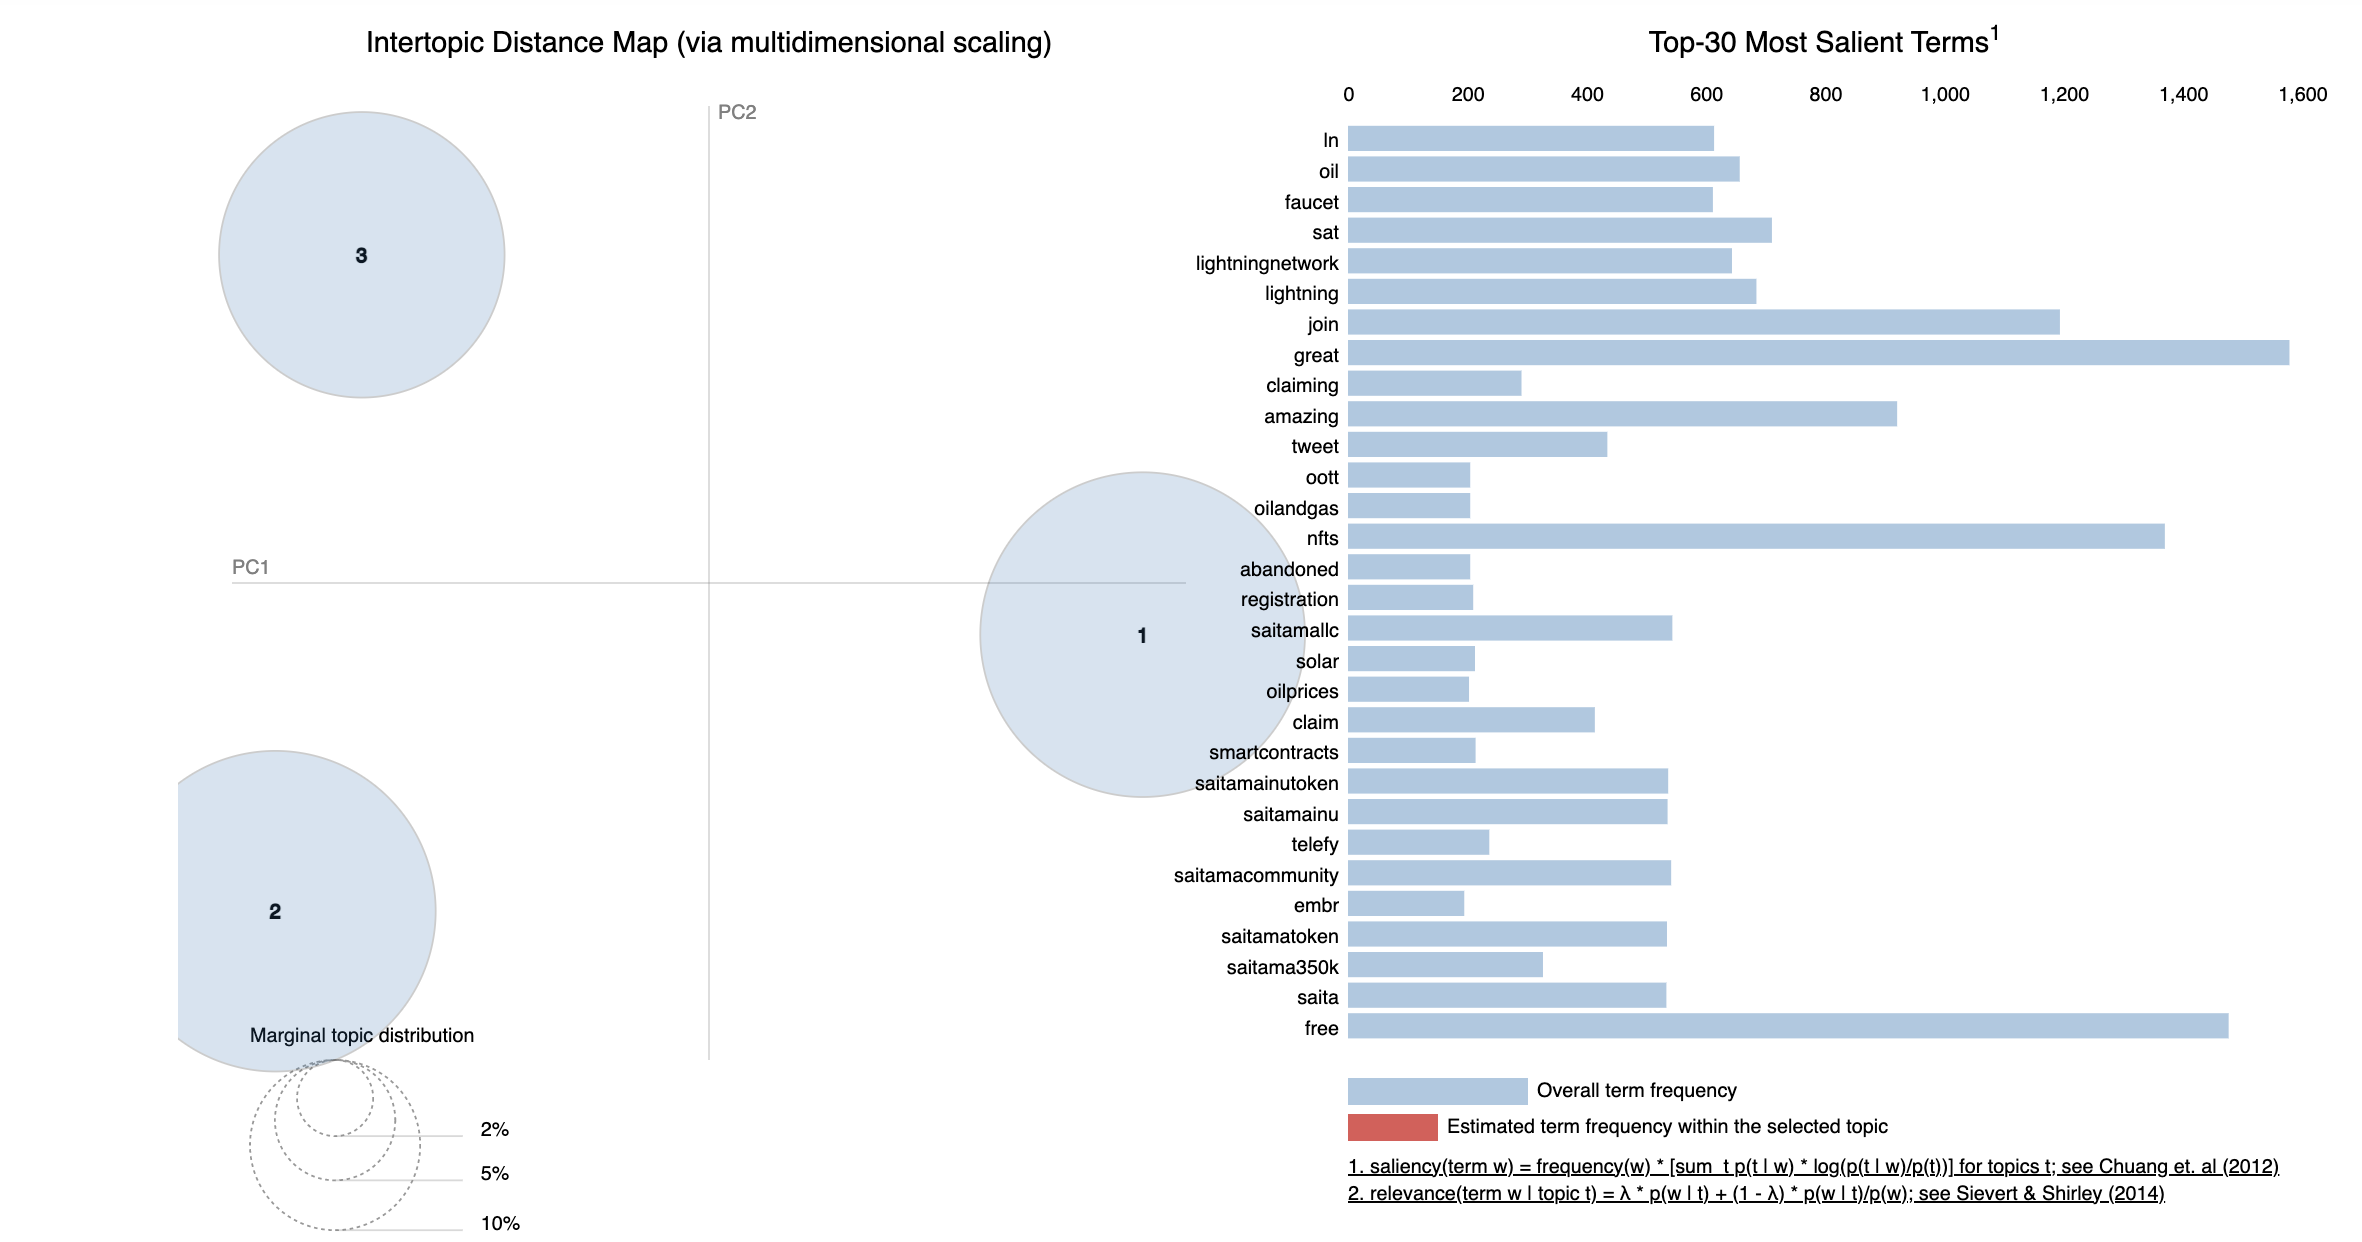

In [208]:
display.Image("./LDA_positive.png")

I used LDA and combine topic modelling with sentiment analysis by setting the sentiment score lower than -0.05 as negative and larger than 0.05 as positive. I did not remove the URL in the text because the link could be an external website, video, gif or a picture. It showed that negative tweets do not contain much URL as the positive ones do. Most of the discussion in the positive one is crypto ‘Saitama’ and crypto related topics while different topics is showed in the negative one, including metaverse, war, nft artists etc.

### Evaluation

In [192]:
# Compute Coherence Score
 #to get coherence value
cm = CoherenceModel(model=My_LDA_positive, corpus=My_Corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
print (coherence)


cm = CoherenceModel(model=My_LDA_negative, corpus=My_Corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
print (coherence)

#Cross validation
df_len0 =df_len[['RiseFall','word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenghth']]
nominal_len = df_len0[['RiseFall']]
numerical_len = df_len0[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenghth']]

le = preprocessing.LabelEncoder()
nominal_len0 = nominal_len.apply(le.fit_transform)

df_crossed_len = pd.concat([numerical_len, nominal_len0], axis=1)

clf = DecisionTreeClassifier (max_depth = 3)
y = df_len0 ["RiseFall"]
X = df_len0.drop(columns=['RiseFall'])

scores = cross_val_score(clf, X, y, cv=6)
scores

-6.544574997629307
-6.124686900885685


array([0.40639426, 0.39876881, 0.40389877, 0.4001368 , 0.39842681,
       0.40441176])

I compute the coherence score and the score from low sentiment and high sentiment is similar, which is -6. I also use the six-fold cross validation to figure out the relationship between bitcoin price and social media. The movement of price has only three options: rise, fall and equal. Therefore, the score must be higher than 33.33%. I choose the word count feature to test the cross-validation score and the result is more than 40% overall. The word count  shows limited information about the price move maybe because of the word limit.